## Requirements

In [ ]:
import sys
if (sys.version_info.major, sys.version_info.minor) == (3, 7):
    print(f"Python version OK")
else:
    print("Incorrect Python version, must be 3.7")

In [ ]:
import os

def check_module(module, install=True, upgrade=True):
    try:
        __import__(module)
        print(f"Module '{module}' OK")
        if upgrade:
            print(f"Upgrading '{module}'...")
            print(os.popen(f"pip install --user -U {module.replace('_', '-')}").read())
        
    except ModuleNotFoundError:
        print(f"Module '{module}' not found")
        if install:
            print(f"Installing '{module}'......")
            print(os.popen(f"pip install --user {module.replace('_', '-')}").read())
            print('Installed')
            check_module(module)

- Modules to install

In [ ]:
modules = [
    'struct',
    'numpy',
    'time',
    'atexit',
    'logging',
    'sys',
    'glob',
    'PyQt5',
    'scipy',
    'seaborn',
    'matplotlib',
    'pyqtgraph',
]

[check_module(module) for module in modules];

## Connection and acquisition

- Board connection

In [1]:
import open_bci as bci
import time as tm
import numpy as np
import struct
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
from numpy import matlib
import seaborn as sns

baud = 115200
board = bci.OpenBCIBoard(port=None, baud = baud, filter_data = True)
print("EEG Channels :",board.eeg_channels_per_sample)
print("Aux Channels :",board.aux_channels_per_sample)



Searching Board...
Serial established...
  OpenBCI V3 8-16 channel
On Board ADS1299 Device ID: 0x3E
LIS3DH Device ID: 0x33
Firmware: v3.1.1
$$$
Connecting to V3 at port /dev/ttyUSB0
EEG Channels : 8
Aux Channels : 3


- Parameters for acquisition

In [2]:
fs = 250.0                     # Sample Frequency
START_BYTE = 0xA0               
END_BYTE = 0xC0                 
TIME = 4                       #Seconds to read
Adquic = int(TIME*fs)          #Samples to read
eeg_raw = []                   #Save raw data

- Stream mode activated

In [3]:
board.ser.write(b'b')
board.streaming = True

- Good reading of data

In [4]:
def read(n):
    b = board.ser.read(n)
    if not b:
        board.warn('Device appears to be stalled. Quitting...')
        sys.exit()
        raise Exception('Device Stalled')
        sys.exit()
        return '\xFF'
    else:
        return b
    

Read_state:
- 0 means that is looking for the start byte
- 1 means that is acquiring data from EEG channels.
- 2 means that is acquiring accelerometer data.
- 3 means that is looking for the end byte

In [5]:
max_bytes_to_skip=10000
board.read_state = 0

def read_data(board, max_bytes_to_skip):
    for rep in range(max_bytes_to_skip):
        
        if board.read_state == 0:
            b = read(1)
            
            if struct.unpack('B', b)[0] == START_BYTE:
                print("START BYTE FOUND: ",b)
                if(rep != 0):
                    board.warn('Skipped %d bytes before start found' %(rep))
                    rep = 0;
                packet_id = struct.unpack('B', read(1))[0] 
                print("PACKET_ID: ",packet_id)
                board.read_state = 1

        elif board.read_state == 1:
            channel_data = []
            print("Obtaining data from EEG Channels...")
            for c in range(board.eeg_channels_per_sample):

                literal_read = read(3)

                unpacked = struct.unpack('3B', literal_read)

                
                if (unpacked[0] > 127):
                    pre_fix = bytes(bytearray.fromhex('FF')) 
                else:
                    pre_fix = bytes(bytearray.fromhex('00'))


                literal_read = pre_fix + literal_read;

                
                myInt = struct.unpack('>i', literal_read)[0]
                print("CH"+str(c)+"= ", myInt)
                channel_data.append(myInt)
                
                board.read_state = 2;

          #---------Accelerometer Data---------
        elif board.read_state == 2:
            aux_data = []
            for a in range(board.aux_channels_per_sample):

                # short = h
                acc = struct.unpack('>h', read(2))[0]
                aux_data.append(acc)

            board.read_state = 3;

        #---------End Byte---------
        elif board.read_state == 3:
            val = struct.unpack('B', read(1))[0]
            board.read_state = 0 
            if (val == END_BYTE):
                print("END BYTE FOUND: ",END_BYTE)
                sample = bci.OpenBCISample(packet_id, channel_data, aux_data)
                board.packets_dropped = 0
               
                return sample
            else:
                board.packets_dropped = board.packets_dropped + 1


 - Data acquisition

In [6]:
for seconds in range(Adquic):
    sample = read_data(board,max_bytes_to_skip)
    eeg_raw.append(sample.channel_data)

START BYTE FOUND:  b'\xa0'
PACKET_ID:  0
Obtaining data from EEG Channels...
CH0=  2533583
CH1=  621519
CH2=  2503889
CH3=  1201346
CH4=  1203948
CH5=  1480698
CH6=  152123
CH7=  1113282
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  1
Obtaining data from EEG Channels...
CH0=  2529286
CH1=  616681
CH2=  2513818
CH3=  1203478
CH4=  1238256
CH5=  1503135
CH6=  225623
CH7=  1171855
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  2
Obtaining data from EEG Channels...
CH0=  2523658
CH1=  616198
CH2=  2490176
CH3=  1198296
CH4=  1222880
CH5=  1490078
CH6=  247849
CH7=  1177425
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  3
Obtaining data from EEG Channels...
CH0=  2528926
CH1=  621711
CH2=  2483075
CH3=  1198683
CH4=  1193886
CH5=  1469988
CH6=  182803
CH7=  1127729
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  4
Obtaining data from EEG Channels...
CH0=  2534758
CH1=  623362
CH2=  2502674
CH3=  1202088
CH4=  1202906
CH5=  1473090
CH6=  15

CH7=  1178831
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  53
Obtaining data from EEG Channels...
CH0=  2520779
CH1=  618779
CH2=  2532888
CH3=  1174172
CH4=  1196674
CH5=  1527918
CH6=  176913
CH7=  1127797
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  54
Obtaining data from EEG Channels...
CH0=  2525910
CH1=  618414
CH2=  2556012
CH3=  1175847
CH4=  1210010
CH5=  1530253
CH6=  149014
CH7=  1111041
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  55
Obtaining data from EEG Channels...
CH0=  2521344
CH1=  613317
CH2=  2571180
CH3=  1178918
CH4=  1244243
CH5=  1552564
CH6=  218248
CH7=  1167391
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  56
Obtaining data from EEG Channels...
CH0=  2515581
CH1=  612968
CH2=  2549871
CH3=  1176263
CH4=  1230539
CH5=  1547258
CH6=  251534
CH7=  1184788
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  57
Obtaining data from EEG Channels...
CH0=  2519758
CH1=  616989
CH2=  2540039
CH3=  1175

PACKET_ID:  120
Obtaining data from EEG Channels...
CH0=  2530030
CH1=  615656
CH2=  2515333
CH3=  1175695
CH4=  1195321
CH5=  1530758
CH6=  161918
CH7=  1114272
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  121
Obtaining data from EEG Channels...
CH0=  2530833
CH1=  612796
CH2=  2532273
CH3=  1177318
CH4=  1214870
CH5=  1540281
CH6=  156701
CH7=  1117331
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  122
Obtaining data from EEG Channels...
CH0=  2524906
CH1=  609667
CH2=  2534377
CH3=  1181178
CH4=  1238991
CH5=  1563257
CH6=  236721
CH7=  1184089
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  123
Obtaining data from EEG Channels...
CH0=  2523884
CH1=  612077
CH2=  2513451
CH3=  1178014
CH4=  1214926
CH5=  1551307
CH6=  236166
CH7=  1174269
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  124
Obtaining data from EEG Channels...
CH0=  2530337
CH1=  615034
CH2=  2513283
CH3=  1176030
CH4=  1195746
CH5=  1533640
CH6=  171446
CH7=  112108

END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  174
Obtaining data from EEG Channels...
CH0=  2530889
CH1=  612963
CH2=  2506957
CH3=  1173139
CH4=  1191566
CH5=  1538169
CH6=  166286
CH7=  1118333
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  175
Obtaining data from EEG Channels...
CH0=  2532793
CH1=  611120
CH2=  2524309
CH3=  1174408
CH4=  1209299
CH5=  1543616
CH6=  152424
CH7=  1112004
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  176
Obtaining data from EEG Channels...
CH0=  2526887
CH1=  607790
CH2=  2528484
CH3=  1179286
CH4=  1235111
CH5=  1568758
CH6=  229466
CH7=  1178439
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  177
Obtaining data from EEG Channels...
CH0=  2524610
CH1=  609578
CH2=  2507043
CH3=  1176583
CH4=  1213129
CH5=  1559663
CH6=  238317
CH7=  1178027
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  178
Obtaining data from EEG Channels...
CH0=  2530321
CH1=  612784
CH2=  2505052
CH3=  1174168
CH4= 

CH4=  1156129
CH5=  1534613
CH6=  146869
CH7=  1101959
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  119
Obtaining data from EEG Channels...
CH0=  2525849
CH1=  602019
CH2=  2518416
CH3=  1181297
CH4=  1186418
CH5=  1555006
CH6=  187931
CH7=  1139834
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  120
Obtaining data from EEG Channels...
CH0=  2519517
CH1=  601453
CH2=  2505166
CH3=  1183109
CH4=  1186047
CH5=  1566873
CH6=  246691
CH7=  1188179
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  121
Obtaining data from EEG Channels...
CH0=  2521858
CH1=  605613
CH2=  2489489
CH3=  1179649
CH4=  1154944
CH5=  1547687
CH6=  204723
CH7=  1150381
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  122
Obtaining data from EEG Channels...
CH0=  2528138
CH1=  606931
CH2=  2500633
CH3=  1177732
CH4=  1153173
CH5=  1535213
CH6=  150178
CH7=  1104313
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  123
Obtaining data from EEG Channels...
CH0= 

CH3=  1181696
CH4=  1157932
CH5=  1552684
CH6=  213489
CH7=  1158143
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  176
Obtaining data from EEG Channels...
CH0=  2526377
CH1=  607874
CH2=  2498471
CH3=  1178692
CH4=  1150941
CH5=  1536978
CH6=  153366
CH7=  1107026
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  177
Obtaining data from EEG Channels...
CH0=  2525991
CH1=  604084
CH2=  2515793
CH3=  1180284
CH4=  1176456
CH5=  1548869
CH6=  163716
CH7=  1119260
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  178
Obtaining data from EEG Channels...
CH0=  2519289
CH1=  601859
CH2=  2512696
CH3=  1184408
CH4=  1191804
CH5=  1570811
CH6=  239379
CH7=  1184433
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  179
Obtaining data from EEG Channels...
CH0=  2518913
CH1=  605140
CH2=  2491845
CH3=  1181054
CH4=  1162079
CH5=  1555774
CH6=  222947
CH7=  1166059
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  180
Obtaining data from EEG Cha

CH4=  1169684
CH5=  1538593
CH6=  148656
CH7=  1102929
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  236
Obtaining data from EEG Channels...
CH0=  2521701
CH1=  602674
CH2=  2521700
CH3=  1185141
CH4=  1194981
CH5=  1567642
CH6=  222172
CH7=  1169377
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  237
Obtaining data from EEG Channels...
CH0=  2518908
CH1=  605629
CH2=  2500244
CH3=  1184544
CH4=  1172038
CH5=  1564144
CH6=  236319
CH7=  1179766
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  238
Obtaining data from EEG Channels...
CH0=  2523754
CH1=  607927
CH2=  2496171
CH3=  1180598
CH4=  1150536
CH5=  1543001
CH6=  174798
CH7=  1125886
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  239
Obtaining data from EEG Channels...
CH0=  2527099
CH1=  605421
CH2=  2511760
CH3=  1178411
CH4=  1164840
CH5=  1538081
CH6=  143853
CH7=  1098111
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  240
Obtaining data from EEG Channels...
CH0= 

CH6=  190381
CH7=  1142294
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  41
Obtaining data from EEG Channels...
CH0=  2527432
CH1=  605974
CH2=  2508887
CH3=  1176120
CH4=  1157872
CH5=  1544863
CH6=  144973
CH7=  1099681
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  42
Obtaining data from EEG Channels...
CH0=  2524818
CH1=  602273
CH2=  2524254
CH3=  1180918
CH4=  1188046
CH5=  1565551
CH6=  186310
CH7=  1136403
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  43
Obtaining data from EEG Channels...
CH0=  2519476
CH1=  603152
CH2=  2511557
CH3=  1185503
CH4=  1184163
CH5=  1580594
CH6=  242812
CH7=  1186947
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  44
Obtaining data from EEG Channels...
CH0=  2521774
CH1=  606886
CH2=  2496101
CH3=  1181837
CH4=  1153681
CH5=  1561756
CH6=  200735
CH7=  1152148
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  45
Obtaining data from EEG Channels...
CH0=  2527109
CH1=  606603
CH2=  25069

CH0=  2530874
CH1=  607250
CH2=  2516231
CH3=  1179183
CH4=  1158300
CH5=  1552072
CH6=  145924
CH7=  1099451
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  65
Obtaining data from EEG Channels...
CH0=  2527941
CH1=  604058
CH2=  2530065
CH3=  1184634
CH4=  1188099
CH5=  1574944
CH6=  194654
CH7=  1142429
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  66
Obtaining data from EEG Channels...
CH0=  2522809
CH1=  605636
CH2=  2514618
CH3=  1188439
CH4=  1178927
CH5=  1587892
CH6=  243918
CH7=  1187494
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  67
Obtaining data from EEG Channels...
CH0=  2525638
CH1=  609188
CH2=  2500976
CH3=  1184185
CH4=  1148754
CH5=  1567391
CH6=  195911
CH7=  1146961
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  68
Obtaining data from EEG Channels...
CH0=  2530832
CH1=  608140
CH2=  2513069
CH3=  1179346
CH4=  1153328
CH5=  1551840
CH6=  146698
CH7=  1100651
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET

PACKET_ID:  115
Obtaining data from EEG Channels...
CH0=  2526491
CH1=  603291
CH2=  2531054
CH3=  1184268
CH4=  1187966
CH5=  1576906
CH6=  198053
CH7=  1146032
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  116
Obtaining data from EEG Channels...
CH0=  2522054
CH1=  605515
CH2=  2514994
CH3=  1188082
CH4=  1177006
CH5=  1587201
CH6=  243466
CH7=  1187576
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  117
Obtaining data from EEG Channels...
CH0=  2525264
CH1=  609178
CH2=  2502639
CH3=  1184071
CH4=  1147900
CH5=  1566702
CH6=  192892
CH7=  1144094
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  118
Obtaining data from EEG Channels...
CH0=  2529808
CH1=  607574
CH2=  2515535
CH3=  1179046
CH4=  1154123
CH5=  1552673
CH6=  146091
CH7=  1099360
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  119
Obtaining data from EEG Channels...
CH0=  2527404
CH1=  603553
CH2=  2531036
CH3=  1182541
CH4=  1184261
CH5=  1572039
CH6=  184555
CH7=  113333

START BYTE FOUND:  b'\xa0'
PACKET_ID:  161
Obtaining data from EEG Channels...
CH0=  2523456
CH1=  602009
CH2=  2528558
CH3=  1184667
CH4=  1190138
CH5=  1582577
CH6=  214142
CH7=  1160363
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  162
Obtaining data from EEG Channels...
CH0=  2519875
CH1=  605035
CH2=  2508068
CH3=  1185476
CH4=  1168768
CH5=  1584097
CH6=  237141
CH7=  1181849
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  163
Obtaining data from EEG Channels...
CH0=  2524519
CH1=  608224
CH2=  2502064
CH3=  1181436
CH4=  1145317
CH5=  1562484
CH6=  178868
CH7=  1131338
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  164
Obtaining data from EEG Channels...
CH0=  2528239
CH1=  605693
CH2=  2517590
CH3=  1177914
CH4=  1158974
CH5=  1553339
CH6=  145216
CH7=  1097964
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  165
Obtaining data from EEG Channels...
CH0=  2524424
CH1=  602134
CH2=  2529365
CH3=  1183505
CH4=  1187816
CH5=  157815

CH1=  601854
CH2=  2529488
CH3=  1183263
CH4=  1183822
CH5=  1575848
CH6=  192476
CH7=  1140314
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  220
Obtaining data from EEG Channels...
CH0=  2519824
CH1=  603958
CH2=  2515101
CH3=  1187733
CH4=  1176756
CH5=  1590356
CH6=  244396
CH7=  1187753
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  221
Obtaining data from EEG Channels...
CH0=  2522934
CH1=  608178
CH2=  2501146
CH3=  1184444
CH4=  1146260
CH5=  1571379
CH6=  198306
CH7=  1148716
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  222
Obtaining data from EEG Channels...
CH0=  2528095
CH1=  607427
CH2=  2512958
CH3=  1179679
CH4=  1149883
CH5=  1556061
CH6=  148373
CH7=  1102015
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  223
Obtaining data from EEG Channels...
CH0=  2526424
CH1=  603525
CH2=  2529466
CH3=  1182681
CH4=  1179464
CH5=  1572704
CH6=  178559
CH7=  1127803
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  224


CH5=  1558700
CH6=  157728
CH7=  1111601
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  25
Obtaining data from EEG Channels...
CH0=  2528298
CH1=  605510
CH2=  2527354
CH3=  1180453
CH4=  1170863
CH5=  1564103
CH6=  159035
CH7=  1110006
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  26
Obtaining data from EEG Channels...
CH0=  2522650
CH1=  604193
CH2=  2527276
CH3=  1187134
CH4=  1187556
CH5=  1590501
CH6=  231993
CH7=  1175959
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  27
Obtaining data from EEG Channels...
CH0=  2521203
CH1=  607880
CH2=  2505596
CH3=  1185585
CH4=  1158226
CH5=  1580651
CH6=  225278
CH7=  1170631
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  28
Obtaining data from EEG Channels...
CH0=  2526775
CH1=  609744
CH2=  2507749
CH3=  1181449
CH4=  1144842
CH5=  1560526
CH6=  165865
CH7=  1119236
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  29
Obtaining data from EEG Channels...
CH0=  2528929
CH1=  6066

Obtaining data from EEG Channels...
CH0=  2520389
CH1=  611851
CH2=  2513183
CH3=  1189106
CH4=  1167204
CH5=  1594332
CH6=  230906
CH7=  1175494
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  80
Obtaining data from EEG Channels...
CH0=  2525591
CH1=  614241
CH2=  2511583
CH3=  1184545
CH4=  1148963
CH5=  1572775
CH6=  169403
CH7=  1121572
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  81
Obtaining data from EEG Channels...
CH0=  2528224
CH1=  611156
CH2=  2528030
CH3=  1181879
CH4=  1167054
CH5=  1568590
CH6=  146706
CH7=  1098475
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  82
Obtaining data from EEG Channels...
CH0=  2523574
CH1=  608500
CH2=  2536218
CH3=  1188743
CH4=  1193297
CH5=  1595978
CH6=  214081
CH7=  1159112
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  83
Obtaining data from EEG Channels...
CH0=  2520027
CH1=  611282
CH2=  2516303
CH3=  1189421
CH4=  1173249
CH5=  1596954
CH6=  238373
CH7=  1181162
END BYTE FOUND:  1

CH1=  613362
CH2=  2514581
CH3=  1181710
CH4=  1151008
CH5=  1566674
CH6=  152604
CH7=  1105234
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  148
Obtaining data from EEG Channels...
CH0=  2525079
CH1=  609401
CH2=  2531958
CH3=  1183044
CH4=  1178349
CH5=  1577250
CH6=  164993
CH7=  1114576
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  149
Obtaining data from EEG Channels...
CH0=  2519277
CH1=  608881
CH2=  2528124
CH3=  1189283
CH4=  1189767
CH5=  1602034
CH6=  236919
CH7=  1179367
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  150
Obtaining data from EEG Channels...
CH0=  2519226
CH1=  612944
CH2=  2507620
CH3=  1187333
CH4=  1158366
CH5=  1588951
CH6=  218880
CH7=  1164988
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  151
Obtaining data from EEG Channels...
CH0=  2524608
CH1=  613527
CH2=  2512221
CH3=  1182703
CH4=  1149020
CH5=  1569069
CH6=  159368
CH7=  1112548
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  152


END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  204
Obtaining data from EEG Channels...
CH0=  2517561
CH1=  611670
CH2=  2508245
CH3=  1186923
CH4=  1161140
CH5=  1590932
CH6=  226448
CH7=  1171329
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  205
Obtaining data from EEG Channels...
CH0=  2523145
CH1=  613614
CH2=  2509096
CH3=  1182421
CH4=  1146600
CH5=  1570236
CH6=  165768
CH7=  1117897
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  206
Obtaining data from EEG Channels...
CH0=  2525139
CH1=  610073
CH2=  2525886
CH3=  1180254
CH4=  1167307
CH5=  1568920
CH6=  150367
CH7=  1101263
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  207
Obtaining data from EEG Channels...
CH0=  2519838
CH1=  607572
CH2=  2531361
CH3=  1187014
CH4=  1190652
CH5=  1596411
CH6=  220138
CH7=  1164653
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  208
Obtaining data from EEG Channels...
CH0=  2516836
CH1=  610776
CH2=  2510218
CH3=  1187197
CH4= 

CH5=  1596751
CH6=  239239
CH7=  1182943
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  7
Obtaining data from EEG Channels...
CH0=  2519959
CH1=  614488
CH2=  2506901
CH3=  1183639
CH4=  1145299
CH5=  1574913
CH6=  182339
CH7=  1133903
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  8
Obtaining data from EEG Channels...
CH0=  2524099
CH1=  612303
CH2=  2521667
CH3=  1179814
CH4=  1157077
CH5=  1564448
CH6=  144511
CH7=  1097194
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  9
Obtaining data from EEG Channels...
CH0=  2520774
CH1=  608825
CH2=  2534569
CH3=  1185231
CH4=  1186819
CH5=  1588214
CH6=  196377
CH7=  1143498
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  10
Obtaining data from EEG Channels...
CH0=  2515598
CH1=  610503
CH2=  2518304
CH3=  1188449
CH4=  1176388
CH5=  1598894
CH6=  242404
CH7=  1185465
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  11
Obtaining data from EEG Channels...
CH0=  2518588
CH1=  613993


Obtaining data from EEG Channels...
CH0=  2516556
CH1=  612916
CH2=  2503656
CH3=  1185558
CH4=  1150984
CH5=  1584179
CH6=  212108
CH7=  1158466
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  70
Obtaining data from EEG Channels...
CH0=  2522244
CH1=  613648
CH2=  2510968
CH3=  1181199
CH4=  1145797
CH5=  1565631
CH6=  154649
CH7=  1106473
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  71
Obtaining data from EEG Channels...
CH0=  2522614
CH1=  609896
CH2=  2528519
CH3=  1182073
CH4=  1172426
CH5=  1574246
CH6=  161881
CH7=  1110876
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  72
Obtaining data from EEG Channels...
CH0=  2516969
CH1=  608666
CH2=  2526419
CH3=  1188653
CH4=  1186324
CH5=  1600079
CH6=  234495
CH7=  1177354
END BYTE FOUND:  192
START BYTE FOUND:  b'\xa0'
PACKET_ID:  73
Obtaining data from EEG Channels...
CH0=  2516032
CH1=  612321
CH2=  2505223
CH3=  1186389
CH4=  1155438
CH5=  1588324
CH6=  221659
CH7=  1167570
END BYTE FOUND:  1

- Scaling and centering

In [7]:
eeg_raw = np.transpose(np.asarray(eeg_raw))
[fil,col] = eeg_raw.shape
for i in range(fil):
    data = eeg_raw[i,:] * 2.23517444553071e-02
    eeg_raw[i,:] = eeg_raw[i,:] - np.mean(eeg_raw[i,:])

- Filtering and visualization

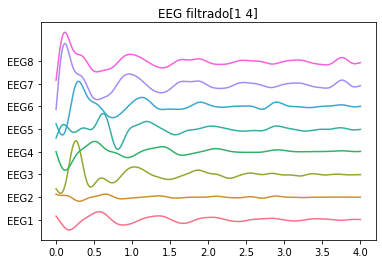

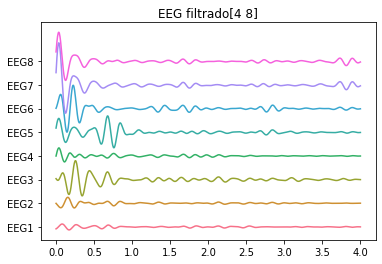

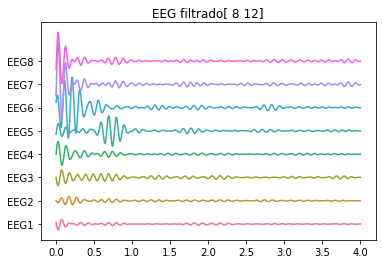

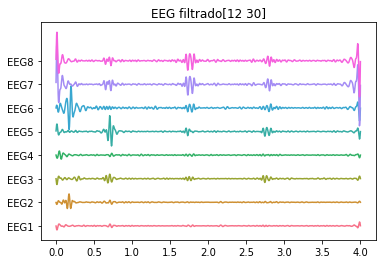

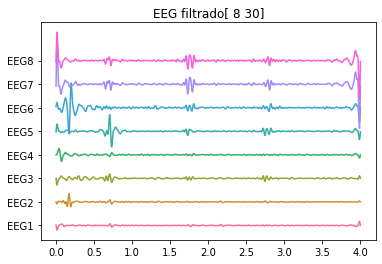

In [8]:
channels_names = ["EEG1","EEG2","EEG3","EEG4","EEG5","EEG6","EEG7","EEG8"]
channels,T = eeg_raw.shape
f_frec = np.array([[1,4],[4,8],[8,12],[12,30],[8,30]])
nf,ff = f_frec.shape
nyq = 0.5 * fs
order = 5
eeg_raw_f = np.zeros((channels,T,nf))

for f in range(nf):
    lfc = f_frec[f,0]
    hfc = f_frec[f,1]            
    low = lfc / nyq
    high = hfc / nyq
    b, a = butter(order, [low, high], btype='band')              
    eeg_raw_f[:,:,f] = filtfilt(b,a,eeg_raw,axis=1) 


for f in range(nf):
    data = eeg_raw_f[:,:,f]  
    plt.figure(f)
    plt.title('EEG filtrado'+str(f_frec[f])) 
    sca=0.75    
    time = np.linspace(0, data.shape[1] / fs, data.shape[1])
    fig = plt.gcf()
    sumf = sca*np.max(sca*(data-matlib.repmat(data.mean(axis=1).reshape(-1,1),1,data.shape[1])))
    plt.yticks(np.arange(0, sumf*len(channels_names),sumf),channels_names)
    color = sns.color_palette('husl',n_colors=data.shape[0])
    for i in range(data.shape[0]): 
        plt.plot(time, (data[i,:] - data[i,:].mean()) + sumf*i,color=color[i])

## GUIs 

#### GUI-RECORD:
Connection, acquisition, filtering, visualization and EEG data storage in a csv file

In [ ]:
%run -i 'GUI_Record.py'

#### GUI-REPLAY:
Filtering and visualization of EEG data read from a csv file

In [ ]:
%run -i 'GUI_Replay.py'